In [1]:
import sys
!{sys.executable} -m pip install cobra
!{sys.executable} -m pip install cobra.test
!{sys.executable} -m pip install cometspy
import cobra
#import cobra.test

import cometspy as c
import os
#os.environ['GUROBI_COMETS_HOME'] = '/opt/gurobi900/linux64'
os.environ['GUROBI_HOME'] = '/Library/gurobi952/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/williamscott/comets_2.10.5_linux'

ERROR: Could not find a version that satisfies the requirement cobra.test (from versions: none)
ERROR: No matching distribution found for cobra.test


## Load models

Since the goal is to reproduce Harcombe et al. (2014), here we load those models directly. However, out of interest, the gene to knockout in the ecoli library to create a methionine auxotroph is metB (b3939), which carries out the reaction SHSL1 (which goes by the synonyms O-succinylhomoserine lyase and cystathionine gamma-synthase). Knocking out the reaction, or the gene (which just knocks out that reaction), will create the "E0" mutant.

For Salmonella, we do two things: cause met_e production from met_c consumption in the biomass reaction, and prevent re-uptake of methionine. In cobra that would look something like this:


met_c = S0.metabolites.met_c

met_e = S0.metabolites.met_e

biomass = S0.reactions.BIOMASS_iRR1083_metals.add_metabolites({met_c : -.5,
                                                             met_e : .5})
                                                             
S0.reactions.METtex.upper_bound = 0

This particular Methylobacterium model was given to me, I believe Harcombe (2014) is its only publication. For this, the hpr gene was deleted.

In [2]:
E = c.model()
E.read_comets_model("./base_files/jmc_EC_iJO_KO.txt")
S = c.model()
S.read_comets_model("./base_files/jmc_SalMet.txt")

# sanity-check simulations

We'll start with well-mixed simulations before doing spatial simulations. No species should grow alone, but they should all grow together. Rerun the next few chunks of code with different initial_pop values to see this. Note that in a community with E and M, M technically increases, but it is marginal. 

In [3]:
E.initial_pop = [0, 0, 1.e-8]
S.initial_pop = [0, 0, 1.e-8]
E.open_exchanges()
S.open_exchanges()
E.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"
S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

# make layout

environmental information. 

Note that the media is the 3-species mutualism media. To make the 2-species (E, S) mutualism media, replace mea\[e] with nh4[e]

In [4]:
l = c.layout([E,S])
base_nutrients = ["ca2[e]", "cl[e]", "cobalt2[e]", "cu2[e]","fe2[e]", "fe3[e]", "k[e]","mg2[e]",
                  "mn2[e]", "mobd[e]", "ni2[e]", "o2[e]", "pi[e]", "so4[e]", "zn2[e]"]
for nutrient in base_nutrients:
    l.set_specific_metabolite(nutrient, 1000)
l.set_specific_metabolite("lcts[e]", 0.000278)
l.set_specific_metabolite("nh4[e]", 0.0015)
#l.set_specific_metabolite("mea[e]", 0.0015)

# make parameters

mathematical parameters and datasaving parameters

In [5]:
p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", 200)
p.set_param("timeStep", 1)

In [6]:
sim = c.comets(l, p)
sim.run()


Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

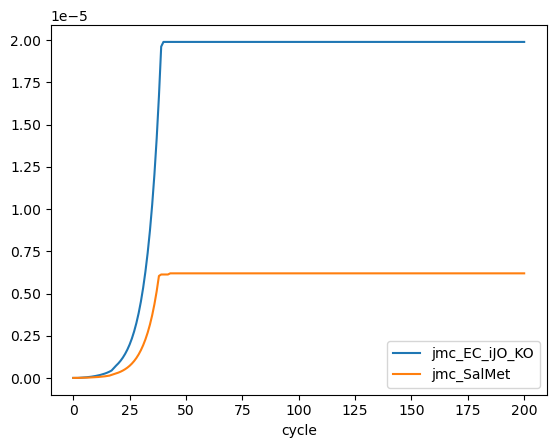

In [7]:
sim.total_biomass.plot(x = "cycle")

# Now remake the layout spatially. 

Note: if you want this to be exactly reproducible, set a seed.

Note: the 3-species simulations used a 15x15 lattice grid, which is done below. The two-species simulations used a 25x25 lattice grid. See the paper for more details.

In [8]:
from cometspy import utils

In [9]:
E_locs = utils.pick_random_locations(n = 16, xrange = [0,25], yrange = [0,25])
S_locs = utils.pick_random_locations(n = 1, xrange = [0,25], yrange = [0,25])
#M_locs = utils.pick_random_locations(n = 83, xrange = [0,15], yrange = [0,15])

E.initial_pop = [[xy[0], xy[1], 3.e-7] for xy in E_locs]
S.initial_pop = [[xy[0], xy[1], 3.e-7] for xy in S_locs]
#M.initial_pop = [[xy[0], xy[1], 3.e-7] for xy in M_locs]

# for example...
E.initial_pop

[[11, 7, 3e-07],
 [16, 13, 3e-07],
 [8, 10, 3e-07],
 [3, 20, 3e-07],
 [1, 7, 3e-07],
 [21, 21, 3e-07],
 [24, 4, 3e-07],
 [2, 8, 3e-07],
 [17, 22, 3e-07],
 [5, 9, 3e-07],
 [10, 17, 3e-07],
 [12, 10, 3e-07],
 [11, 21, 3e-07],
 [24, 23, 3e-07],
 [19, 22, 3e-07],
 [0, 5, 3e-07]]

In [10]:
l = c.layout([E,S])
l.grid = [25, 25]
for nutrient in base_nutrients:
    l.set_specific_metabolite(nutrient, 1000)
l.set_specific_metabolite("lcts[e]", 0.000278)
l.set_specific_metabolite("nh4[e]", 0.0015)
#l.set_specific_metabolite("mea[e]", 0.0015)

In [11]:
p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", 196)
p.set_param("timeStep", 1) #hr
p.set_param("writeBiomassLog", True)
p.set_param("BiomassLogRate", 1)
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("spaceWidth", 0.05) #cm
p.set_param("defaultDiffConst", 5.e-6) #cm2/s; metabolites
p.set_param("flowDiffRate", 3.e-9) #cm2/s; biomass

# Note: I set the time step to 1 hour, and 96 cycles. This can take awhile on a laptop (30 min or so). In the actual paper, the time step was 0.1 hours, and therefore 960 cycles were used. This will take much longer.


Running COMETS simulation ...


/opt/anaconda3/lib/python3.9/site-packages/cometspy/comets.py:422: DtypeWarning: Columns (4,5,7,8,9,11,12,13,15,24,26,28,29,30,31,32,33,36,37,38,45,46,47,48,49,50,51,52,55,57,60,62,63,64,65,70,71,72,73,74,76,81,82,83,85,87,88,90,91,92,93,94,95,96,97,98,99,101,102,103,104,105,106,107,109,110,111,112,119,123,124,127,129,130,131,132,133,134,140,141,143,144,146,148,149,151,152,153,154,155,158,159,161,162,163,164,165,166,167,169,176,179,181,185,187,188,189,190,192,193,194,195,196,198,199,200,201,202,204,205,206,207,208,210,212,213,214,215,216,218,221,232,233,234,236,237,238,240,242,243,244,245,246,248,254,255,256,257,259,261,263,264,265,266,272,275,276,279,280,281,284,285,287,288,289,290,291,292,293,294,295,298,299,304,306,311,316,318,320,321,323,326,327,330,331,332,335,336,337,338,339,340,341,342,343,344,345,346,348,349,350,351,354,355,356,357,358,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,396,

Done!


<AxesSubplot:xlabel='cycle'>

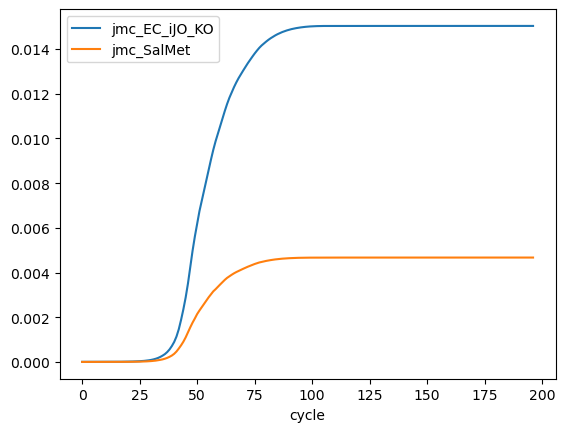

In [12]:
sim = c.comets(l, p)
sim.run()
sim.total_biomass.plot(x = "cycle")

At this point, if you wished to do transfers like in the paper, repeat the simulation but with different values for n in pick_random_locations, which are based on the final frequency obtainable from total_biomass.

In [13]:
sim.total_biomass

cycle  jmc_EC_iJO_KO    jmc_SalMet
0        0       0.000005  3.000000e-07
1        1       0.000005  2.999669e-07
2        2       0.000005  3.083703e-07
3        3       0.000005  3.289580e-07
4        4       0.000005  3.611969e-07
..     ...            ...           ...
192    192       0.015035  4.670522e-03
193    193       0.015035  4.670522e-03
194    194       0.015035  4.670522e-03
195    195       0.015035  4.670522e-03
196    196       0.015035  4.670522e-03

[197 rows x 3 columns]

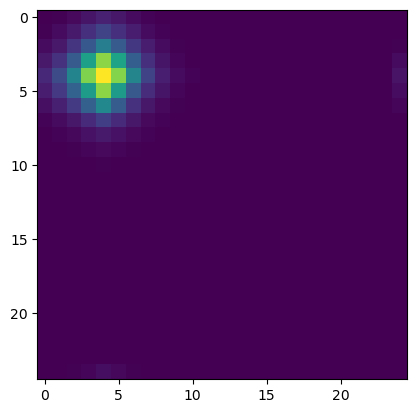

In [14]:
im = sim.get_biomass_image( "jmc_SalMet", 48) # e.g. the salmonella model
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im)

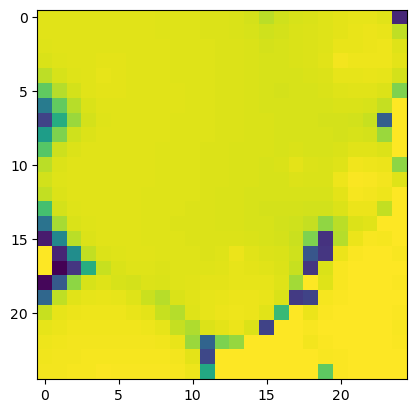

In [15]:
im_2 = sim.get_flux_image("jmc_EC_iJO_KO", "EX_met-L(e)", 48)
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_2)

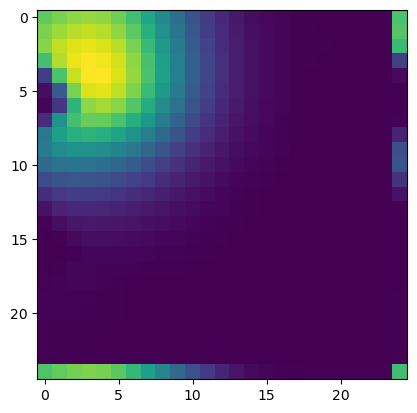

In [16]:
im_3 = sim.get_biomass_image( "jmc_EC_iJO_KO", 48) # e.g. the ecoli model
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_3)

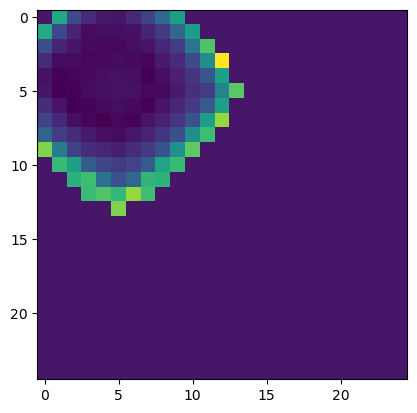

In [17]:
im_4 = sim.get_flux_image("jmc_SalMet", "EX_ac(e)", 48)
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_4)

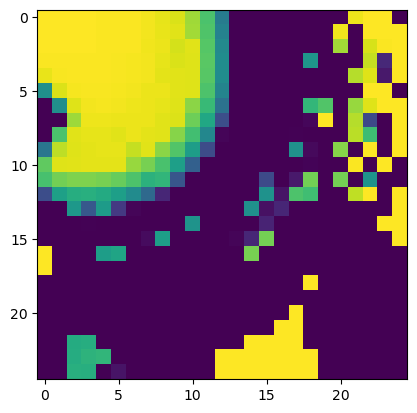

In [18]:
im_5 = sim.get_flux_image("jmc_EC_iJO_KO", "EX_lcts(e)", 48)
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_5)

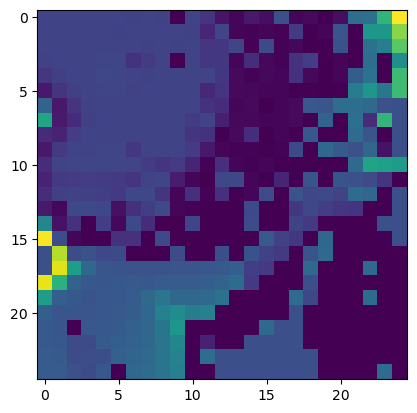

In [19]:
im_6 = sim.get_flux_image("jmc_EC_iJO_KO", "EX_nh4(e)", 48)
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_6)

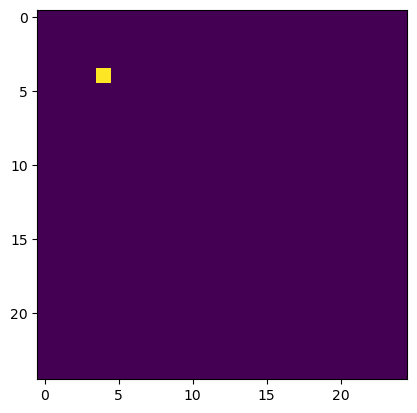

In [20]:
im_7 = sim.get_biomass_image( "jmc_SalMet", 0) # e.g. the salmonella model
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_7)

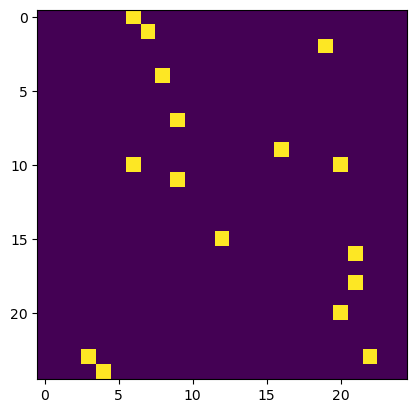

In [21]:
im_8 = sim.get_biomass_image( "jmc_EC_iJO_KO", 0) # e.g. the ecoli model
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_8)

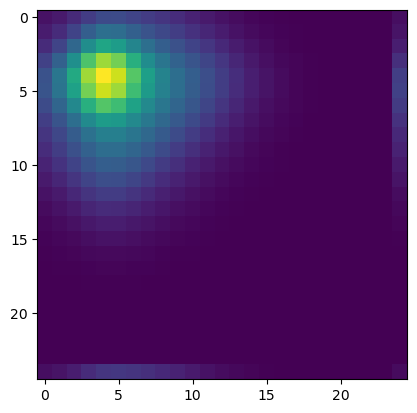

In [23]:
im_9 = sim.get_biomass_image( "jmc_SalMet", 196) # e.g. the salmonella model
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_9)

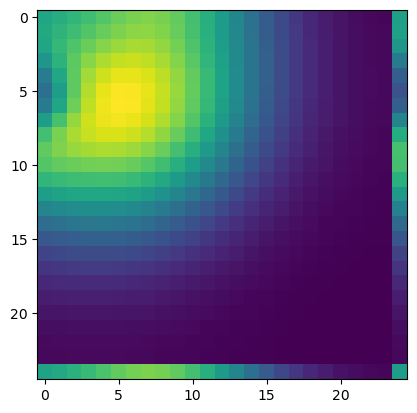

In [24]:
im_10 = sim.get_biomass_image( "jmc_EC_iJO_KO", 196) # e.g. the ecoli model
from matplotlib import pyplot as plt # may need to be installed
plt.imshow(im_10)